In [ ]:
import os
from datetime import datetime

# Path to the log file where all debug messages will be stored
LOG_PATH = "./log.txt"

# -------------------------------------------------
# Create the log file if it does not already exist
# -------------------------------------------------
# This prevents errors when trying to write logs
# and ensures previous logs are not overwritten.
if not os.path.exists(LOG_PATH):
    with open(LOG_PATH, "w") as f:
        # Write an initial header with creation timestamp
        f.write(f"=== Debug Log Created at {datetime.now()} ===\n")


def debug_log(message: str):
    """
    Utility function to write debug messages with timestamps.

    This function:
    1. Adds a timestamp to the message
    2. Prints the message to notebook output (for real-time monitoring)
    3. Appends the message to log.txt (for persistent logging)
    """

    # Generate timestamp for the current log entry
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    # Format the log entry with timestamp
    entry = f"[{timestamp}] {message}\n"

    # Print log entry to notebook output
    # Useful for monitoring training progress live
    print(entry, end="")

    # Append the log entry to the log file
    # Using append mode ensures previous logs are preserved
    with open(LOG_PATH, "a") as f:
        f.write(entry)


In [ ]:
# ==============================
# Operating System & Utility Libraries
# ==============================
# Used for file system operations, directory handling, and image file processing
import shutil
import itertools
import pathlib
from PIL import Image


# ==============================
# Data Handling & Visualization Libraries
# ==============================
# OpenCV for image processing
import cv2

# Matplotlib for plotting images and graphs
import matplotlib.pyplot as plt

# Numerical computing
import numpy as np

# DataFrame manipulation
import pandas as pd

# Statistical visualization
import seaborn as sns
sns.set_style('whitegrid')  # Apply clean grid style to all plots

# Dataset splitting and preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Model evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report


# ==============================
# Deep Learning Libraries
# ==============================
# Core TensorFlow library
import tensorflow as tf

# Lazy loader for Keras (used internally by TensorFlow)
from tensorflow import _KerasLazyLoader as keras

# Keras model and layers for CNN architecture
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Activation, Dense, Dropout, BatchNormalization

# Optimizers used for training
from keras.optimizers import Adam, Adamax

# Loss function for multi-class classification
from keras.losses import SparseCategoricalCrossentropy

# Regularization techniques to reduce overfitting
from keras import regularizers


# ==============================
# Warning Configuration
# ==============================
# Suppress unnecessary warnings to keep notebook output clean
import warnings
warnings.filterwarnings('ignore')


# ==============================
# Environment Check
# ==============================
# Print TensorFlow version to ensure compatibility and reproducibility
print("TensorFlow:", tf.__version__)


# ==============================
# Debug Logging
# ==============================
# Log that all libraries were successfully imported
debug_log("Initialized environment and imported all required libraries.")


TensorFlow: 2.20.0
[2025-12-15 22:54:10] Initialized environment and imported all required libraries.


In [ ]:
# ==============================
# Dataset Path Configuration
# ==============================
# Root directory containing class subfolders
# Example structure:
# ../Three_Classes/
# ├── Reject/
# ├── Ripe/
# └── Unripe/
data_path = "../Three_Classes"


# ==============================
# Initialize Containers
# ==============================
# Lists to store full image paths and corresponding class labels
filepaths = []
labels = []


# ==============================
# Discover Class Folders
# ==============================
# Automatically detect class names from folder structure
# Sorting ensures consistent class order
folds = sorted([
    f for f in os.listdir(data_path)
    if os.path.isdir(os.path.join(data_path, f))
])


# ==============================
# Collect Image Paths and Labels
# ==============================
# Iterate through each class folder
for fold in folds:
    f_path = os.path.join(data_path, fold)

    # Iterate through files in the class directory
    # Only image files are included to avoid system files (e.g., thumbs.db)
    for file in os.listdir(f_path):
        if file.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".webp")):
            filepaths.append(os.path.join(f_path, file))
            labels.append(fold)


# ==============================
# Create Dataset DataFrame
# ==============================
# Combine file paths and labels into a single DataFrame
df = pd.DataFrame({
    "filepaths": filepaths,
    "label": labels
})


# ==============================
# Optional Shuffling
# ==============================
# Shuffle the DataFrame once for better randomness when inspecting data
# This does NOT affect the final split since stratified splitting is used later
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


# ==============================
# Dataset Overview
# ==============================
# Display sample entries and dataset statistics
print(df.head())
print("\nTotal images:", len(df))
print("\nClass counts:")
print(df["label"].value_counts())


# ==============================
# Debug Logging
# ==============================
# Log dataset loading summary for traceability
debug_log(
    f"Loaded dataset paths: {len(df)} images found across {len(folds)} folders ({', '.join(folds)})."
)


                                  filepaths   label
0  ../Three_Classes\Unripe\unripe (493).jpg  Unripe
1   ../Three_Classes\Unripe\unripe (44).jpg  Unripe
2  ../Three_Classes\Ripe\healthy (1113).jpg    Ripe
3  ../Three_Classes\Unripe\unripe (206).jpg  Unripe
4  ../Three_Classes\Unripe\unripe (477).jpg  Unripe

Total images: 2400

Class counts:
label
Unripe    800
Ripe      800
Reject    800
Name: count, dtype: int64
[2025-12-15 22:54:12] Loaded dataset paths: 2400 images found across 3 folders (Reject, Ripe, Unripe).


In [15]:
from sklearn.model_selection import train_test_split

SEED = 42

# df must contain: ["filepaths", "label"]
# df = pd.DataFrame({"filepaths": filepaths, "label": labels})

# 1) Split out TRAIN (70%) and TEMP (30%)
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    random_state=SEED,
    stratify=df["label"]
)

# 2) Split TEMP into VAL (15%) and TEST (15%)
# temp is 30% of total, so val needs to be half of temp => 0.50
valid_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    random_state=SEED,
    stratify=temp_df["label"]
)

# reset index (optional but cleaner)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

print("Total :", len(df))
print("Train :", len(train_df))
print("Valid :", len(valid_df))
print("Test  :", len(test_df))

print("\nClass distribution (Train):")
print(train_df["label"].value_counts())
print("\nClass distribution (Valid):")
print(valid_df["label"].value_counts())
print("\nClass distribution (Test):")
print(test_df["label"].value_counts())

debug_log(
    f"Split done (stratified): train={len(train_df)} ({len(train_df)/len(df):.1%}), "
    f"valid={len(valid_df)} ({len(valid_df)/len(df):.1%}), "
    f"test={len(test_df)} ({len(test_df)/len(df):.1%})."
)


Total : 2400
Train : 1680
Valid : 360
Test  : 360

Class distribution (Train):
label
Ripe      560
Reject    560
Unripe    560
Name: count, dtype: int64

Class distribution (Valid):
label
Reject    120
Ripe      120
Unripe    120
Name: count, dtype: int64

Class distribution (Test):
label
Reject    120
Unripe    120
Ripe      120
Name: count, dtype: int64
[2025-12-15 22:54:14] Split done (stratified): train=1680 (70.0%), valid=360 (15.0%), test=360 (15.0%).


In [ ]:
# ==============================
# Image & Training Configuration
# ==============================
# Target image size for the model input
# EfficientNetB0 is designed to work well with 224x224 images
img_size = (224, 224)

# Number of images per batch during training
# Larger batch size improves GPU utilization if VRAM allows
batch_size = 32  # 16 can be used if GPU memory is limited


# ==============================
# Class Encoding
# ==============================
# Extract unique class names from training data
# Sorting ensures consistent class-to-index mapping
class_names = sorted(train_df["label"].unique())

# Create a mapping from class name to numeric index
class_to_index = {name: idx for idx, name in enumerate(class_names)}


def encode_df(df):
    """
    Encode string class labels into integer indices.
    This is required for SparseCategoricalCrossentropy.
    """
    df = df.copy()
    df["label_idx"] = df["label"].map(class_to_index).astype("int32")
    return df


# Encode labels for train, validation, and test sets
train_df_enc = encode_df(train_df)
valid_df_enc = encode_df(valid_df)
test_df_enc  = encode_df(test_df)

# Total number of classes
num_classes = len(class_names)

# Display detected classes
print("Classes:", class_names)


# ==============================
# Data Augmentation (Training Only)
# ==============================
# Augmentation is applied ONLY to training images
# This helps improve generalization and reduce overfitting
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.08),
    tf.keras.layers.RandomZoom(0.10),
    tf.keras.layers.RandomContrast(0.10),
], name="aug")


# ==============================
# Image Preprocessing
# ==============================
# EfficientNet models require a specific preprocessing function
from keras.applications.efficientnet import preprocess_input


def load_and_preprocess(path, label, training=False):
    """
    Load an image from disk and apply preprocessing.
    If training=True, data augmentation is applied.
    """
    # Read image file from disk
    img = tf.io.read_file(path)

    # Decode JPEG image and force 3 color channels (RGB)
    img = tf.image.decode_jpeg(img, channels=3)

    # Resize image to model input size
    img = tf.image.resize(img, img_size)

    # Convert image to float32
    img = tf.cast(img, tf.float32)

    # Apply data augmentation only during training
    if training:
        img = data_augmentation(img, training=True)

    # Apply EfficientNet-specific preprocessing
    # (scaling and normalization expected by pretrained weights)
    img = preprocess_input(img)

    return img, label


# ==============================
# Convert DataFrame to tf.data.Dataset
# ==============================
def df_to_dataset(df, training=False):
    """
    Convert a DataFrame containing image paths and labels
    into a TensorFlow Dataset pipeline.
    """
    paths = df["filepaths"].values
    labels = df["label_idx"].values

    # Create dataset from file paths and labels
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    # Load and preprocess images in parallel
    ds = ds.map(
        lambda p, y: load_and_preprocess(p, y, training=training),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Shuffle dataset only during training
    if training:
        ds = ds.shuffle(
            buffer_size=len(df),
            reshuffle_each_iteration=True
        )

    # Batch and prefetch for performance optimization
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return ds


# ==============================
# Build Final Datasets
# ==============================
# Training dataset (with augmentation)
train_ds = df_to_dataset(train_df_enc, training=True)

# Validation dataset (no augmentation)
valid_ds = df_to_dataset(valid_df_enc, training=False)

# Test dataset (no augmentation)
test_ds  = df_to_dataset(test_df_enc, training=False)


# ==============================
# Debug Logging
# ==============================
# Log dataset pipeline readiness
debug_log(
    f"Datasets ready (aug+preprocess_input). "
    f"batch_size={batch_size}, classes={class_names}"
)


Classes: ['Reject', 'Ripe', 'Unripe']
[2025-12-15 22:54:17] Datasets ready (aug+preprocess_input). batch_size=32, classes=['Reject', 'Ripe', 'Unripe']


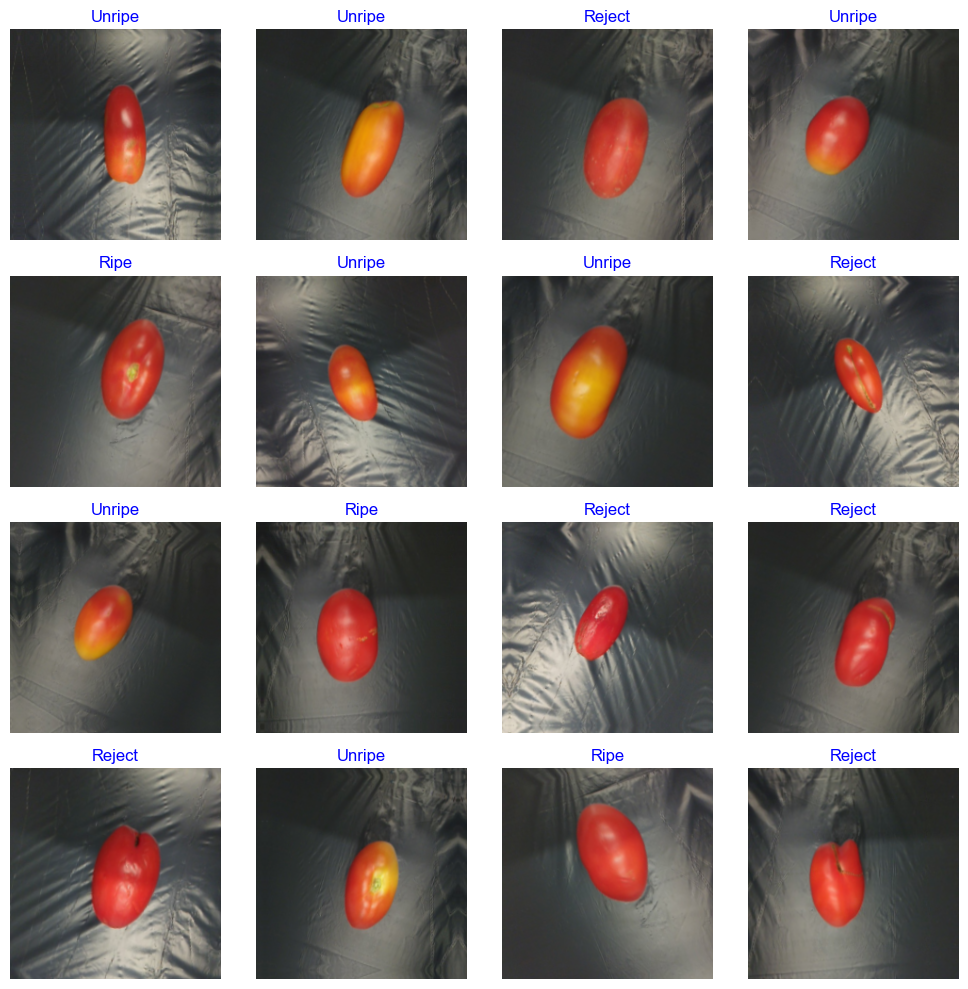

[2025-12-15 22:54:20] Visualized a training batch — batch_size=32, labels=['Unripe', 'Unripe', 'Reject', 'Unripe', 'Ripe', 'Unripe', 'Unripe', 'Reject', 'Unripe', 'Ripe', 'Reject', 'Reject', 'Reject', 'Unripe', 'Ripe', 'Reject', 'Unripe', 'Reject', 'Unripe', 'Ripe', 'Reject', 'Reject', 'Ripe', 'Reject', 'Ripe', 'Reject', 'Reject', 'Unripe', 'Ripe', 'Reject', 'Ripe', 'Reject'].


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ==============================
# Retrieve One Batch from Training Dataset
# ==============================
# Take a single batch from the training dataset to visualize
images_batch, labels_batch = next(iter(train_ds))


def to_display_image(img: np.ndarray) -> np.ndarray:
    """
    Convert preprocessed image tensors back into a displayable format
    suitable for matplotlib visualization.

    This function supports:
    - EfficientNet preprocess_input output (value range ~[-1, 1])
    - Normalized images in range [0, 1]
    - Raw images in range [0, 255]
    """
    img = img.astype(np.float32)

    # Case 1: EfficientNet preprocessing outputs values in [-1, 1]
    # Convert back to [0, 1] for visualization
    if img.min() < 0.0:
        img = (img + 1.0) / 2.0

    # Case 2: Raw pixel values in [0, 255]
    # Normalize to [0, 1]
    if img.max() > 1.5:
        img = img / 255.0

    # Ensure all values are within valid display range
    return np.clip(img, 0.0, 1.0)


# ==============================
# Visualize Training Images
# ==============================
# Display up to 16 images from the training batch
plt.figure(figsize=(10, 10))
for i in range(min(16, len(images_batch))):
    plt.subplot(4, 4, i + 1)

    # Convert tensor to NumPy array
    img = images_batch[i].numpy()

    # Convert preprocessed image back to displayable format
    img = to_display_image(img)

    # Retrieve label index and corresponding class name
    lbl = int(labels_batch[i].numpy())

    # Display image and its label
    plt.imshow(img)
    plt.title(class_names[lbl], color="blue", fontsize=12)
    plt.axis("off")

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()


# ==============================
# Debug Logging
# ==============================
# Log batch visualization details for traceability
debug_log(
    f"Visualized a training batch — batch_size={len(images_batch)}, "
    f"labels={ [class_names[int(x)] for x in labels_batch.numpy()] }."
)


In [ ]:
# ==============================
# Model Input Configuration
# ==============================
# Define input shape based on image size and RGB channels
img_shape = (img_size[0], img_size[1], 3)

# Number of output classes (Reject, Ripe, Unripe)
num_class = num_classes  # derived from encoded labels


# ==============================
# Load Pretrained Backbone (EfficientNetB0)
# ==============================
# EfficientNetB0 is used as a feature extractor
# - include_top=False removes the original classifier
# - weights="imagenet" enables transfer learning
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=img_shape
)

# Freeze backbone weights during Phase 1 training
# This prevents pretrained features from being modified initially
base_model.trainable = False


# ==============================
# Build Custom Classification Head
# ==============================
# Define model input
inputs = tf.keras.Input(shape=img_shape)

# Pass inputs through the pretrained backbone
# training=False ensures BatchNorm layers run in inference mode
x = base_model(inputs, training=False)

# Reduce spatial dimensions and convert feature maps to a vector
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Apply dropout to reduce overfitting
x = tf.keras.layers.Dropout(0.35)(x)

# Final classification layer using softmax activation
# Outputs class probabilities
outputs = tf.keras.layers.Dense(num_class, activation="softmax")(x)


# ==============================
# Assemble the Model
# ==============================
model = tf.keras.Model(inputs, outputs)


# ==============================
# Compile Model
# ==============================
# Adam optimizer with low learning rate for stable transfer learning
# SparseCategoricalCrossentropy is used because labels are integer-encoded
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[
        "accuracy",
        # Top-2 accuracy provides additional insight into near-miss predictions
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=2, name="top2_acc")
    ]
)


# ==============================
# Model Summary & Logging
# ==============================
# Display model architecture and parameter counts
model.summary()

# Log successful model compilation
debug_log("Model compiled: EfficientNetB0 frozen + GAP + Dropout.")


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,053,414 (15.46 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

[2025-12-15 22:54:22] Model compiled: EfficientNetB0 frozen + GAP + Dropout.


In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger

# ==============================
# Model & Log Save Paths
# ==============================
# Directory where trained models and logs will be stored
MODEL_DIR = "../model"

# Path to save the best model based on validation loss
BEST_MODEL_PATH = os.path.join(MODEL_DIR, "best_tomato_model.keras")

# Path to save the final trained model after all training phases
FINAL_MODEL_PATH = os.path.join(MODEL_DIR, "tomatoes_classifier_model.keras")

# Path to save per-epoch training logs in CSV format
LOG_PATH = os.path.join(MODEL_DIR, "training_log.csv")


# ==============================
# Safe Directory Creation
# ==============================
# Ensure model directory exists before saving any files
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
    debug_log(f"Created model directory: {MODEL_DIR}")
else:
    debug_log(f"Model directory exists: {MODEL_DIR}")


# ==============================
# Custom Epoch Debug Logger
# ==============================
# This callback logs training metrics at the end of each epoch
# It helps track training progress and learning rate changes
class EpochDebugLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}

        # Retrieve current learning rate from optimizer
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))

        # Write detailed epoch information to debug log
        debug_log(
            f"Epoch {epoch + 1:03d} | "
            f"loss={logs.get('loss', 0):.4f}, "
            f"acc={logs.get('accuracy', 0):.4f}, "
            f"val_loss={logs.get('val_loss', 0):.4f}, "
            f"val_acc={logs.get('val_accuracy', 0):.4f}, "
            f"lr={lr:.2e}"
        )


# ==============================
# Callback Configuration
# ==============================
# EarlyStopping: stops training when validation loss stops improving
# ReduceLROnPlateau: lowers learning rate when validation loss plateaus
# ModelCheckpoint: saves the best model during training
# CSVLogger: saves epoch-wise metrics into a CSV file
# EpochDebugLogger: custom logger for detailed epoch logging
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=2,
        min_lr=1e-6
    ),
    ModelCheckpoint(
        BEST_MODEL_PATH,
        monitor="val_loss",
        save_best_only=True
    ),
    CSVLogger(LOG_PATH, append=True),
    EpochDebugLogger()
]


# ==============================
# Phase 1: Feature Extraction Training
# ==============================
# Train only the custom classification head
# Pretrained EfficientNet backbone remains frozen
history1 = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)


# ==============================
# Phase 2: Fine-Tuning
# ==============================
# Unfreeze the top layers of the backbone for deeper feature adaptation
base_model.trainable = True

# Freeze lower layers to maintain stable pretrained features
for layer in base_model.layers[:-80]:
    layer.trainable = False


# Recompile model with a smaller learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)


# Continue training with fine-tuning enabled
history2 = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=30,
    callbacks=callbacks,
    verbose=1
)


# ==============================
# Save Final Model and Logs
# ==============================
# Save the fully trained model
model.save(FINAL_MODEL_PATH)

# Log training completion
debug_log(f"Training finished (2-phase). Final model saved to {FINAL_MODEL_PATH}")
debug_log(f"Training log saved to {LOG_PATH}")


[2025-12-15 22:54:27] Model directory exists: ../model
Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.3104 - loss: 1.2634 - top2_acc: 0.6394[2025-12-15 22:54:43] Epoch 001 | loss=1.2449, acc=0.3214, val_loss=1.1551, val_acc=0.4111, lr=2.00e-05
53/53 ━━━━━━━━━━━━━━━━━━━━ 16s 208ms/step - accuracy: 0.3214 - loss: 1.2449 - top2_acc: 0.6500 - val_accuracy: 0.4111 - val_loss: 1.1551 - val_top2_acc: 0.6028 - learning_rate: 2.0000e-05
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.3297 - loss: 1.1977 - top2_acc: 0.6688[2025-12-15 22:54:53] Epoch 002 | loss=1.1789, acc=0.3494, val_loss=1.1435, val_acc=0.4639, lr=2.00e-05
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step - accuracy: 0.3494 - loss: 1.1789 - top2_acc: 0.6792 - val_accuracy: 0.4639 - val_loss: 1.1435 - val_top2_acc: 0.6472 - learning_rate: 2.0000e-05
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.3507 - loss: 1.1743 - top2_acc: 0.6712[2025-12-15 22:55:03] Epoch 003 | loss=1.1526, ac

In [20]:
import numpy as np

y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
y_proba = model.predict(test_ds, verbose=0)
y_pred = np.argmax(y_proba, axis=1)

wrong_idx = np.where(y_true != y_pred)[0]
print("Total Data:", len(test_df))
print("Total wrong:", len(wrong_idx))

# show first 12 wrong predictions
paths = test_df_enc["filepaths"].values  # if you're using encoded df; otherwise test_df
for i in wrong_idx[:12]:
    true_lbl = class_names[y_true[i]]
    pred_lbl = class_names[y_pred[i]]
    conf = y_proba[i, y_pred[i]] * 100
    print(f"{paths[i]} | true={true_lbl} pred={pred_lbl} conf={conf:.2f}%")

Total Data: 360
Total wrong: 32
../Three_Classes\Ripe\healthy (1460).jpg | true=Ripe pred=Reject conf=83.99%
../Three_Classes\Reject\reject (34).jpg | true=Reject pred=Unripe conf=90.63%
../Three_Classes\Ripe\healthy (1423).jpg | true=Ripe pred=Reject conf=59.09%
../Three_Classes\Reject\reject (231).jpg | true=Reject pred=Ripe conf=55.34%
../Three_Classes\Ripe\healthy (352).jpg | true=Ripe pred=Reject conf=57.71%
../Three_Classes\Ripe\healthy (9).jpg | true=Ripe pred=Reject conf=69.17%
../Three_Classes\Reject\reject (257).jpg | true=Reject pred=Ripe conf=78.73%
../Three_Classes\Ripe\healthy (374).jpg | true=Ripe pred=Reject conf=62.62%
../Three_Classes\Reject\reject (54).jpg | true=Reject pred=Ripe conf=60.87%
../Three_Classes\Ripe\healthy (4).jpg | true=Ripe pred=Reject conf=58.74%
../Three_Classes\Reject\reject (475).jpg | true=Reject pred=Unripe conf=74.84%
../Three_Classes\Reject\reject (464).jpg | true=Reject pred=Ripe conf=51.70%


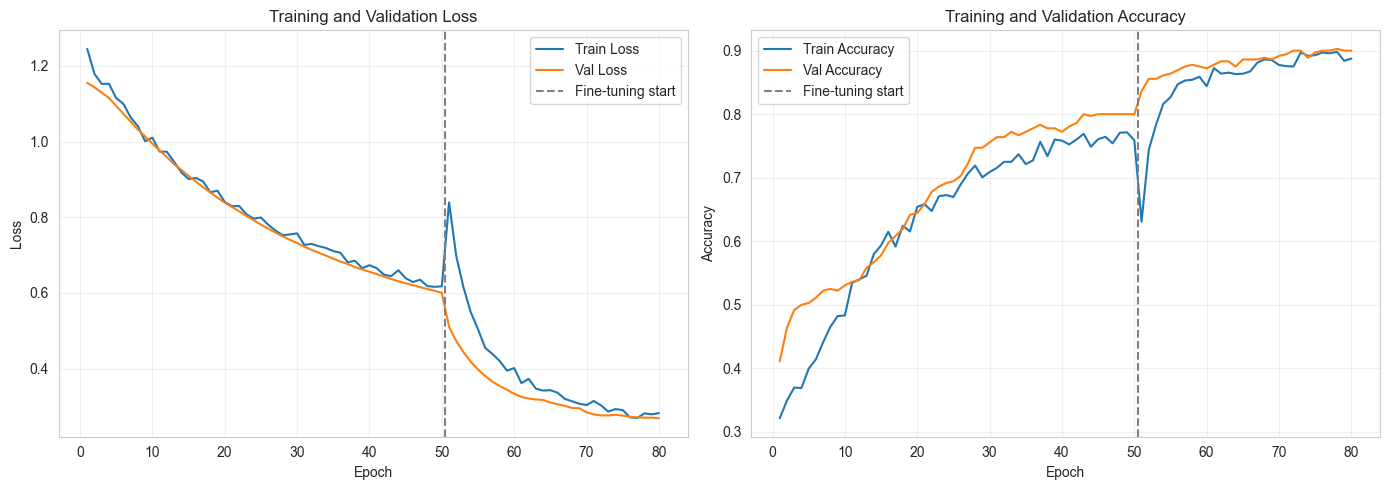

[2025-12-15 23:11:25] Plotted training curves (2-phase). Total epochs=80 | Final Train Loss=0.2825, Val Loss=0.2690 | Final Train Acc=0.8875, Val Acc=0.9000


In [21]:
# ===== Combine training histories (phase 1 + phase 2) =====

train_loss = history1.history["loss"] + history2.history["loss"]
val_loss   = history1.history["val_loss"] + history2.history["val_loss"]
train_acc  = history1.history["accuracy"] + history2.history["accuracy"]
val_acc    = history1.history["val_accuracy"] + history2.history["val_accuracy"]

epochs_range = range(1, len(train_loss) + 1)
fine_tune_start = len(history1.history["loss"]) + 0.5

plt.figure(figsize=(14, 5))

# ===== Loss plot =====
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label="Train Loss")
plt.plot(epochs_range, val_loss, label="Val Loss")
plt.axvline(fine_tune_start, linestyle="--", color="gray", label="Fine-tuning start")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(alpha=0.3)

# ===== Accuracy plot =====
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc, label="Train Accuracy")
plt.plot(epochs_range, val_acc, label="Val Accuracy")
plt.axvline(fine_tune_start, linestyle="--", color="gray", label="Fine-tuning start")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ===== DEBUG LOG =====
debug_log(
    f"Plotted training curves (2-phase). "
    f"Total epochs={len(train_loss)} | "
    f"Final Train Loss={train_loss[-1]:.4f}, Val Loss={val_loss[-1]:.4f} | "
    f"Final Train Acc={train_acc[-1]:.4f}, Val Acc={val_acc[-1]:.4f}"
)


In [22]:
train_score = model.evaluate(train_ds, verbose=1)
valid_score = model.evaluate(valid_ds, verbose=1)
test_score  = model.evaluate(test_ds,  verbose=1)

print("Train:", train_score)
print("Valid:", valid_score)
print("Test :", test_score)

debug_log(f"Eval full dataset — Train={train_score}, Valid={valid_score}, Test={test_score}")

53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 0.9155 - loss: 0.2098
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9000 - loss: 0.2690
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9111 - loss: 0.2415
Train: [0.20982173085212708, 0.9154762029647827]
Valid: [0.2689778804779053, 0.8999999761581421]
Test : [0.24151840806007385, 0.9111111164093018]
[2025-12-15 23:11:42] Eval full dataset — Train=[0.20982173085212708, 0.9154762029647827], Valid=[0.2689778804779053, 0.8999999761581421], Test=[0.24151840806007385, 0.9111111164093018]


In [23]:
preds = model.predict(train_ds)
y_pred = np.argmax(preds, axis=1)

# === DEBUG LOG ===
debug_log(
    f"Generated predictions for training dataset — total_preds={len(y_pred)}, "
    f"sample_predictions={y_pred[:10].tolist()}."
)

53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step
[2025-12-15 23:11:55] Generated predictions for training dataset — total_preds=1680, sample_predictions=[2, 0, 0, 1, 2, 0, 1, 1, 1, 1].


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step
Classification Report:

              precision    recall  f1-score   support

      Reject       0.89      0.87      0.88       120
        Ripe       0.91      0.90      0.90       120
      Unripe       0.94      0.97      0.95       120

    accuracy                           0.91       360
   macro avg       0.91      0.91      0.91       360
weighted avg       0.91      0.91      0.91       360



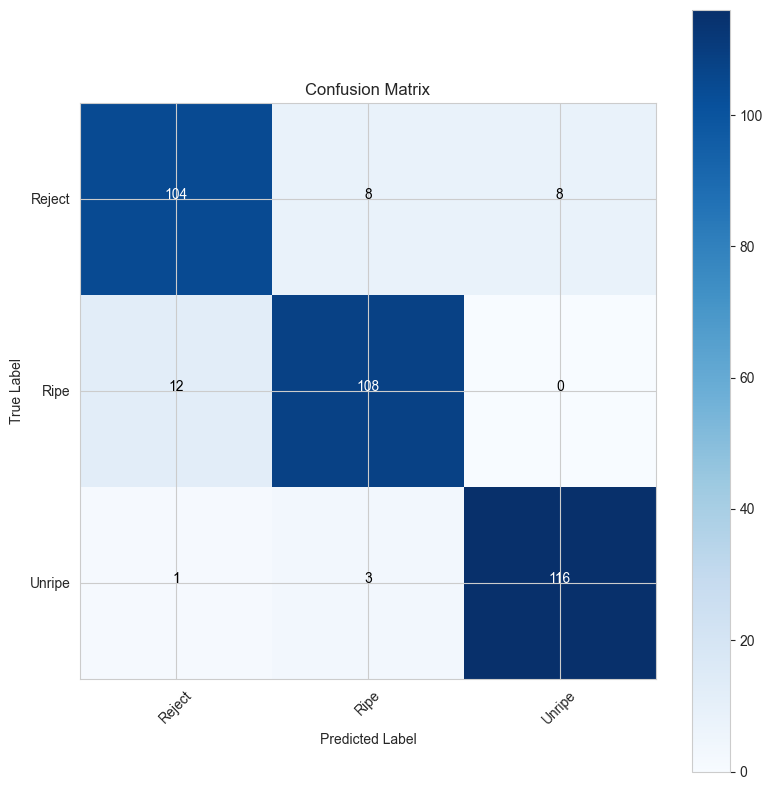

[2025-12-15 23:12:12] Generated classification report and confusion matrix — test_samples=360, sample_y_true=[0, 2, 0, 2, 1, 2, 0, 1, 2, 0], sample_y_pred=[0, 2, 0, 2, 1, 2, 0, 1, 2, 0].


In [24]:
# collect true labels from test_ds
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

# predicted probabilities
y_proba = model.predict(test_ds)
y_pred = np.argmax(y_proba, axis=1)

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(
        j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )

plt.tight_layout()
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# === DEBUG LOG ===
debug_log(
    f"Generated classification report and confusion matrix — "
    f"test_samples={len(y_true)}, "
    f"sample_y_true={y_true[:10].tolist()}, "
    f"sample_y_pred={y_pred[:10].tolist()}."
)